In [1]:
# CELL 0: Environment Setup (Run this FIRST)
# Install all required dependencies
import subprocess
import sys

packages = [
    'numpy',
    'pandas',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'tensorflow',
    'keras',
    'joblib'
]

print("Installing required packages...")
for package in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

print("\nVerifying installations...")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
import time
import os

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All dependencies installed successfully!")
print(f"NumPy: {np.__version__}")
print(f"TensorFlow: {tf.__version__}")
print(f"Scikit-learn: {pd.__version__}")

Installing required packages...

Verifying installations...
✓ All dependencies installed successfully!
NumPy: 1.26.4
TensorFlow: 2.16.2
Scikit-learn: 2.3.3


In [2]:



# ============================================================
# CELL 1: Data Loading and Initial Exploration
# ============================================================

print("\n" + "="*80)
print("SECTION 1: DATA LOADING, EXPLORATION, AND PREPROCESSING")
print("="*80)

# Load CIFAR-10 dataset
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

print("\nDataset loaded successfully!")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# CIFAR-10 class definitions
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"\nNumber of classes: {len(class_names)}")
print(f"Class names: {', '.join(class_names)}")

# Check for class imbalance
unique_train, counts_train = np.unique(y_train, return_counts=True)
print(f"\nClass distribution (training set):")
for cls_idx, count in zip(unique_train, counts_train):
    print(f"  {class_names[cls_idx]:12s}: {count:5d} samples ({100*count/len(y_train):.1f}%)")



SECTION 1: DATA LOADING, EXPLORATION, AND PREPROCESSING

Dataset loaded successfully!
Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)

Number of classes: 10
Class names: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

Class distribution (training set):
  airplane    :  5000 samples (10.0%)
  automobile  :  5000 samples (10.0%)
  bird        :  5000 samples (10.0%)
  cat         :  5000 samples (10.0%)
  deer        :  5000 samples (10.0%)
  dog         :  5000 samples (10.0%)
  frog        :  5000 samples (10.0%)
  horse       :  5000 samples (10.0%)
  ship        :  5000 samples (10.0%)
  truck       :  5000 samples (10.0%)


In [3]:
# ============================================================
# CELL 2: Detailed Data Exploration
# ============================================================

print("\n" + "-"*80)
print("DATA EXPLORATION AND ANALYSIS")
print("-"*80)

# Pixel intensity statistics
print(f"\nPixel intensity statistics (raw images 0-255):")
print(f"  Minimum value: {X_train.min()}")
print(f"  Maximum value: {X_train.max()}")
print(f"  Mean value:    {X_train.mean():.2f}")
print(f"  Std deviation: {X_train.std():.2f}")

# Compute per-channel statistics
print(f"\nPer-channel statistics:")
for channel_idx, channel_name in enumerate(['Red', 'Green', 'Blue']):
    channel_data = X_train[:, :, :, channel_idx]
    print(f"  {channel_name}: mean={channel_data.mean():.2f}, std={channel_data.std():.2f}")

# Check image properties
print(f"\nImage properties:")
print(f"  Image shape: {X_train[0].shape}")
print(f"  Data type: {X_train.dtype}")
print(f"  Total number of pixels per image: {32 * 32 * 3}")



--------------------------------------------------------------------------------
DATA EXPLORATION AND ANALYSIS
--------------------------------------------------------------------------------

Pixel intensity statistics (raw images 0-255):
  Minimum value: 0
  Maximum value: 255
  Mean value:    120.71
  Std deviation: 64.15

Per-channel statistics:
  Red: mean=125.31, std=62.99
  Green: mean=122.95, std=62.09
  Blue: mean=113.87, std=66.70

Image properties:
  Image shape: (32, 32, 3)
  Data type: uint8
  Total number of pixels per image: 3072


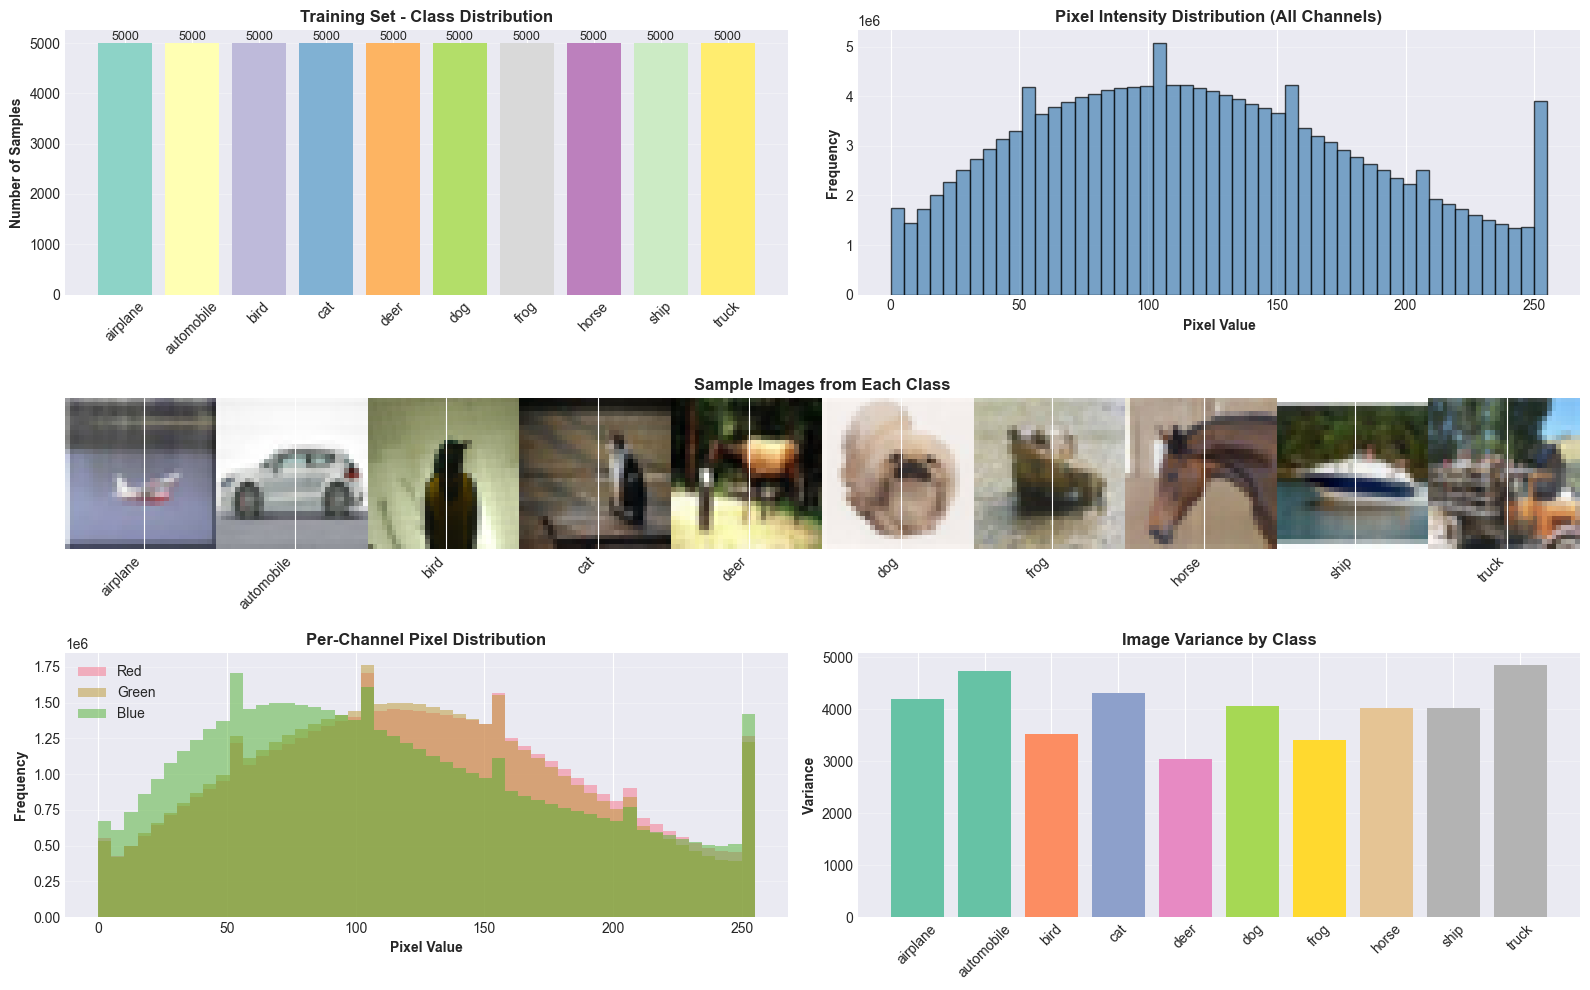

✓ Data exploration completed!


In [4]:
# ============================================================
# CELL 3: Visualize Sample Images and Class Distribution
# ============================================================

fig = plt.figure(figsize=(16, 10))

# Row 1: Class distribution
ax1 = plt.subplot(3, 2, 1)
unique, counts = np.unique(y_train, return_counts=True)
bars = ax1.bar(class_names, counts, color=plt.cm.Set3(np.linspace(0, 1, 10)))
ax1.set_title('Training Set - Class Distribution', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Samples', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Row 1: Pixel intensity distribution
ax2 = plt.subplot(3, 2, 2)
ax2.hist(X_train.flatten(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_title('Pixel Intensity Distribution (All Channels)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Pixel Value', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Row 2: Sample images from each class
ax3 = plt.subplot(3, 2, (3, 4))
sample_images = []
for class_idx in range(10):
    class_samples = np.where(y_train == class_idx)[0]
    sample_idx = class_samples[np.random.randint(0, len(class_samples))]
    sample_images.append(X_train[sample_idx].astype(np.uint8))

sample_grid = np.concatenate(sample_images, axis=1)
ax3.imshow(sample_grid)
ax3.set_title('Sample Images from Each Class', fontsize=12, fontweight='bold')
ax3.set_xticks([i*32 + 16 for i in range(10)])
ax3.set_xticklabels(class_names, rotation=45, ha='right')
ax3.set_yticks([])

# Row 3: Per-channel intensity distribution
ax4 = plt.subplot(3, 2, 5)
for channel_idx, channel_name in enumerate(['Red', 'Green', 'Blue']):
    channel_data = X_train[:, :, :, channel_idx].flatten()
    ax4.hist(channel_data, bins=50, alpha=0.5, label=channel_name)
ax4.set_title('Per-Channel Pixel Distribution', fontsize=12, fontweight='bold')
ax4.set_xlabel('Pixel Value', fontweight='bold')
ax4.set_ylabel('Frequency', fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Row 3: Image variance by class
ax5 = plt.subplot(3, 2, 6)
class_variances = []
for class_idx in range(10):
    class_samples = X_train[y_train == class_idx]
    variance = np.var(class_samples)
    class_variances.append(variance)
bars = ax5.bar(class_names, class_variances, color=plt.cm.Set2(np.linspace(0, 1, 10)))
ax5.set_title('Image Variance by Class', fontsize=12, fontweight='bold')
ax5.set_ylabel('Variance', fontweight='bold')
ax5.tick_params(axis='x', rotation=45)
ax5.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Data exploration completed!")


In [5]:
# ============================================================
# CELL 4: Data Preprocessing
# ============================================================

print("\n" + "-"*80)
print("DATA PREPROCESSING")
print("-"*80)

print("\nPreprocessing steps applied:")
print("1. Normalization: Scaling to [0, 1] range")
print("   - Reason: Improves neural network convergence and gradient stability")
print("   - Effect: Reduces dependency on initial weight magnitudes")
print("\n2. Data augmentation (for neural networks):")
print("   - Reason: Increases model generalization on limited CIFAR-10 data")
print("   - Techniques: Random rotations, shifts, flips")
print("\n3. Train-validation-test split:")
print("   - Reason: Separate data for tuning and final evaluation")
print("   - Method: Stratified split to preserve class distribution")

# Normalize to [0, 1] range
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

# Stratified train-validation split (80-20)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_normalized, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

# Flatten for traditional ML (Random Forest)
X_train_split_flat = X_train_split.reshape(X_train_split.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test_normalized.reshape(X_test_normalized.shape[0], -1)
X_train_flat = X_train_normalized.reshape(X_train_normalized.shape[0], -1)

# Data augmentation pipeline for neural networks
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

print(f"\nData split results:")
print(f"  Training set:   {X_train_split.shape[0]:,} samples")
print(f"  Validation set: {X_val.shape[0]:,} samples")
print(f"  Test set:       {X_test_normalized.shape[0]:,} samples")
print(f"\nNormalized pixel range: [{X_train_normalized.min()}, {X_train_normalized.max()}]")
print(f"Flattened feature dimension: {X_train_split_flat.shape[1]}")

print("\n✓ Preprocessing completed!")



--------------------------------------------------------------------------------
DATA PREPROCESSING
--------------------------------------------------------------------------------

Preprocessing steps applied:
1. Normalization: Scaling to [0, 1] range
   - Reason: Improves neural network convergence and gradient stability
   - Effect: Reduces dependency on initial weight magnitudes

2. Data augmentation (for neural networks):
   - Reason: Increases model generalization on limited CIFAR-10 data
   - Techniques: Random rotations, shifts, flips

3. Train-validation-test split:
   - Reason: Separate data for tuning and final evaluation
   - Method: Stratified split to preserve class distribution

Data split results:
  Training set:   40,000 samples
  Validation set: 10,000 samples
  Test set:       10,000 samples

Normalized pixel range: [0.0, 1.0]
Flattened feature dimension: 3072

✓ Preprocessing completed!


In [6]:
# ============================================================
# CELL 5: Algorithm 1 - Random Forest
# ============================================================

print("\n" + "="*80)
print("SECTION 2: ALGORITHM DESIGN AND SETUP")
print("="*80)

print("\n" + "-"*80)
print("ALGORITHM 1: RANDOM FOREST CLASSIFIER")
print("-"*80)

print("\nAlgorithm description:")
print("Random Forest is an ensemble method combining multiple decision trees.")
print("It reduces variance through aggregation and provides robust predictions.")
print("\nKey hyperparameters:")
print("  - n_estimators: Number of trees in the forest")
print("  - max_depth: Maximum tree depth (controls complexity)")
print("  - min_samples_split: Minimum samples to split node (regularization)")

# Initialize default Random Forest
rf_model_default = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("\nDefault Random Forest model initialized")
print("Ready for hyperparameter tuning...")



SECTION 2: ALGORITHM DESIGN AND SETUP

--------------------------------------------------------------------------------
ALGORITHM 1: RANDOM FOREST CLASSIFIER
--------------------------------------------------------------------------------

Algorithm description:
Random Forest is an ensemble method combining multiple decision trees.
It reduces variance through aggregation and provides robust predictions.

Key hyperparameters:
  - n_estimators: Number of trees in the forest
  - max_depth: Maximum tree depth (controls complexity)
  - min_samples_split: Minimum samples to split node (regularization)

Default Random Forest model initialized
Ready for hyperparameter tuning...


In [7]:
# ============================================================
# CELL 6: Algorithm 2 - Multilayer Perceptron
# ============================================================

print("\n" + "-"*80)
print("ALGORITHM 2: MULTILAYER PERCEPTRON (MLP)")
print("-"*80)

print("\nArchitecture design rationale:")
print("- Input layer: Flattened 32x32x3 = 3072 features")
print("- Hidden layers: [512, 256, 128] neurons with decreasing capacity")
print("- Activation: ReLU for non-linearity, softmax for output probabilities")
print("- Regularization: L2 penalty, batch normalization, dropout")
print("- Why this design:")
print("    * Progressive reduction focuses learning on most discriminative features")
print("    * Batch normalization stabilizes training and allows higher learning rates")
print("    * Dropout prevents co-adaptation of neurons (overfitting control)")

def create_mlp_model(input_size=3072, hidden_layers=[512, 256, 128],
                     dropout_rate=0.3, learning_rate=0.001, l2_lambda=0.001):
    """
    Create a Multilayer Perceptron model for image classification.
    
    Args:
        input_size: Total flattened input features (3072 for CIFAR-10)
        hidden_layers: List containing neuron counts for each hidden layer
        dropout_rate: Fraction of neurons to randomly drop during training
        learning_rate: Step size for Adam optimizer
        l2_lambda: L2 regularization strength to prevent overfitting
    
    Returns:
        Compiled Keras Sequential model
    """
    model = Sequential()
    
    # Flatten input images
    model.add(layers.Flatten(input_shape=(32, 32, 3)))
    
    # Add hidden layers with regularization
    for hidden_units in hidden_layers:
        model.add(layers.Dense(
            hidden_units, 
            activation='relu',
            kernel_regularizer=regularizers.l2(l2_lambda)
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))
    
    # Output layer: 10 neurons for 10 classes
    model.add(layers.Dense(10, activation='softmax'))
    
    # Compile with Adam optimizer
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create sample MLP model to show architecture
mlp_sample = create_mlp_model()
print("\nSample MLP Architecture:")
print(f"Total parameters: {mlp_sample.count_params():,}")
mlp_sample.summary()

print("\n✓ MLP model setup completed!")



--------------------------------------------------------------------------------
ALGORITHM 2: MULTILAYER PERCEPTRON (MLP)
--------------------------------------------------------------------------------

Architecture design rationale:
- Input layer: Flattened 32x32x3 = 3072 features
- Hidden layers: [512, 256, 128] neurons with decreasing capacity
- Activation: ReLU for non-linearity, softmax for output probabilities
- Regularization: L2 penalty, batch normalization, dropout
- Why this design:
    * Progressive reduction focuses learning on most discriminative features
    * Batch normalization stabilizes training and allows higher learning rates
    * Dropout prevents co-adaptation of neurons (overfitting control)

Sample MLP Architecture:
Total parameters: 1,742,474


2025-10-24 20:01:47.130843: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-10-24 20:01:47.131021: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-10-24 20:01:47.131026: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-10-24 20:01:47.131213: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-24 20:01:47.131226: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,742,474 (6.65 MB)

 Trainable params: 1,740,682 (6.64 MB)

 Non-trainable params: 1,792 (7.00 KB)


✓ MLP model setup completed!


In [8]:
# ============================================================
# CELL 7: Algorithm 3 - Convolutional Neural Network
# ============================================================

print("\n" + "-"*80)
print("ALGORITHM 3: CONVOLUTIONAL NEURAL NETWORK (CNN)")
print("-"*80)

print("\nArchitecture design rationale:")
print("- Conv layers: Learn spatial feature hierarchies")
print("- Filter progression: 32 → 64 → 128 (increasing feature complexity)")
print("- Kernel size: 3x3 captures local patterns effectively")
print("- Max pooling: Spatial downsampling, computational efficiency")
print("- Why CNNs excel on images:")
print("    * Parameter sharing exploits spatial structure")
print("    * Local connectivity models natural image properties")
print("    * Translation invariance through pooling improves generalization")

def create_cnn_model(filters=[32, 64, 128], kernel_size=3,
                     dropout_rate=0.3, learning_rate=0.001, l2_lambda=0.001):
    """
    Create a Convolutional Neural Network for image classification.
    
    Args:
        filters: List of filter counts for each convolutional block
        kernel_size: Size of convolutional kernels (typically 3 or 5)
        dropout_rate: Fraction of activations to drop
        learning_rate: Adam optimizer learning rate
        l2_lambda: L2 regularization coefficient
    
    Returns:
        Compiled Keras Sequential model
    """
    model = Sequential()
    
    # First convolutional block: 2 conv layers + batch norm + pooling
    model.add(layers.Conv2D(
        filters[0], kernel_size,
        activation='relu',
        padding='same',
        input_shape=(32, 32, 3),
        kernel_regularizer=regularizers.l2(l2_lambda)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(
        filters[0], kernel_size,
        activation='relu',
        padding='same'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout_rate))
    
    # Second convolutional block
    model.add(layers.Conv2D(
        filters[1], kernel_size,
        activation='relu',
        padding='same'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(
        filters[1], kernel_size,
        activation='relu',
        padding='same'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout_rate))
    
    # Third convolutional block
    model.add(layers.Conv2D(
        filters[2], kernel_size,
        activation='relu',
        padding='same'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(
        filters[2], kernel_size,
        activation='relu',
        padding='same'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout_rate))
    
    # Flatten and dense classification layers
    model.add(layers.Flatten())
    model.add(layers.Dense(
        256, 
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_lambda)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    
    # Output layer
    model.add(layers.Dense(10, activation='softmax'))
    
    # Compile model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create sample CNN model
cnn_sample = create_cnn_model()
print("\nSample CNN Architecture:")
print(f"Total parameters: {cnn_sample.count_params():,}")
cnn_sample.summary()

print("\n✓ CNN model setup completed!")



--------------------------------------------------------------------------------
ALGORITHM 3: CONVOLUTIONAL NEURAL NETWORK (CNN)
--------------------------------------------------------------------------------

Architecture design rationale:
- Conv layers: Learn spatial feature hierarchies
- Filter progression: 32 → 64 → 128 (increasing feature complexity)
- Kernel size: 3x3 captures local patterns effectively
- Max pooling: Spatial downsampling, computational efficiency
- Why CNNs excel on images:
    * Parameter sharing exploits spatial structure
    * Local connectivity models natural image properties
    * Translation invariance through pooling improves generalization

Sample CNN Architecture:
Total parameters: 816,938


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)


✓ CNN model setup completed!


In [15]:
# ============================================================
# CELL 8: Random Forest Hyperparameter Tuning
# ============================================================

print("\n" + "="*80)
print("SECTION 3: HYPERPARAMETER TUNING")
print("="*80)

print("\n" + "-"*80)
print("RANDOM FOREST - HYPERPARAMETER TUNING")
print("-"*80)

print("\nTuning Strategy: Grid Search on Validation Set")
print("Reason: Memory-efficient compared to cross-validation on large flattened data")

# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5]
}

print(f"\nHyperparameter search space:")
print(f"  n_estimators: {rf_param_grid['n_estimators']}")
print(f"  max_depth: {rf_param_grid['max_depth']}")
print(f"  min_samples_split: {rf_param_grid['min_samples_split']}")
print(f"  Total combinations: {np.prod([len(v) for v in rf_param_grid.values()])}")

print("\nPerforming grid search (this may take 10-15 minutes)...")

rf_results_list = []
best_rf_accuracy = 0
best_rf_params = None
rf_tune_start = time.time()

for n_est in rf_param_grid['n_estimators']:
    for max_d in rf_param_grid['max_depth']:
        for min_split in rf_param_grid['min_samples_split']:
            # Create and train model
            rf = RandomForestClassifier(
                n_estimators=n_est,
                max_depth=max_d,
                min_samples_split=min_split,
                random_state=42,
                n_jobs=-1
            )
            
            train_start = time.time()
            rf.fit(X_train_split_flat, y_train_split)
            train_time = time.time() - train_start
            
            # Evaluate
            val_acc = rf.score(X_val_flat, y_val)
            
            rf_results_list.append({
                'n_estimators': n_est,
                'max_depth': max_d,
                'min_samples_split': min_split,
                'val_accuracy': val_acc,
                'train_time': train_time
            })
            
            print(f"n_est={n_est}, depth={max_d}, split={min_split}: "
                  f"Val Acc={val_acc:.4f}, Time={train_time:.1f}s")
            
            if val_acc > best_rf_accuracy:
                best_rf_accuracy = val_acc
                best_rf_params = {
                    'n_estimators': n_est,
                    'max_depth': max_d,
                    'min_samples_split': min_split
                }

rf_tune_time = time.time() - rf_tune_start
rf_results_df = pd.DataFrame(rf_results_list)

print(f"\nBest Random Forest Parameters:")
print(f"  {best_rf_params}")
print(f"  Best Validation Accuracy: {best_rf_accuracy:.4f}")
print(f"Total tuning time: {rf_tune_time/60:.1f} minutes")




SECTION 3: HYPERPARAMETER TUNING

--------------------------------------------------------------------------------
RANDOM FOREST - HYPERPARAMETER TUNING
--------------------------------------------------------------------------------

Tuning Strategy: Grid Search on Validation Set
Reason: Memory-efficient compared to cross-validation on large flattened data

Hyperparameter search space:
  n_estimators: [100, 200, 300]
  max_depth: [15, 20, 25]
  min_samples_split: [2, 5]
  Total combinations: 18

Performing grid search (this may take 10-15 minutes)...
n_est=100, depth=15, split=2: Val Acc=0.4490, Time=9.5s
n_est=100, depth=15, split=5: Val Acc=0.4506, Time=9.2s
n_est=100, depth=20, split=2: Val Acc=0.4545, Time=10.4s
n_est=100, depth=20, split=5: Val Acc=0.4564, Time=10.6s
n_est=100, depth=25, split=2: Val Acc=0.4571, Time=11.5s
n_est=100, depth=25, split=5: Val Acc=0.4558, Time=11.0s
n_est=200, depth=15, split=2: Val Acc=0.4578, Time=18.8s
n_est=200, depth=15, split=5: Val Acc=0.4559

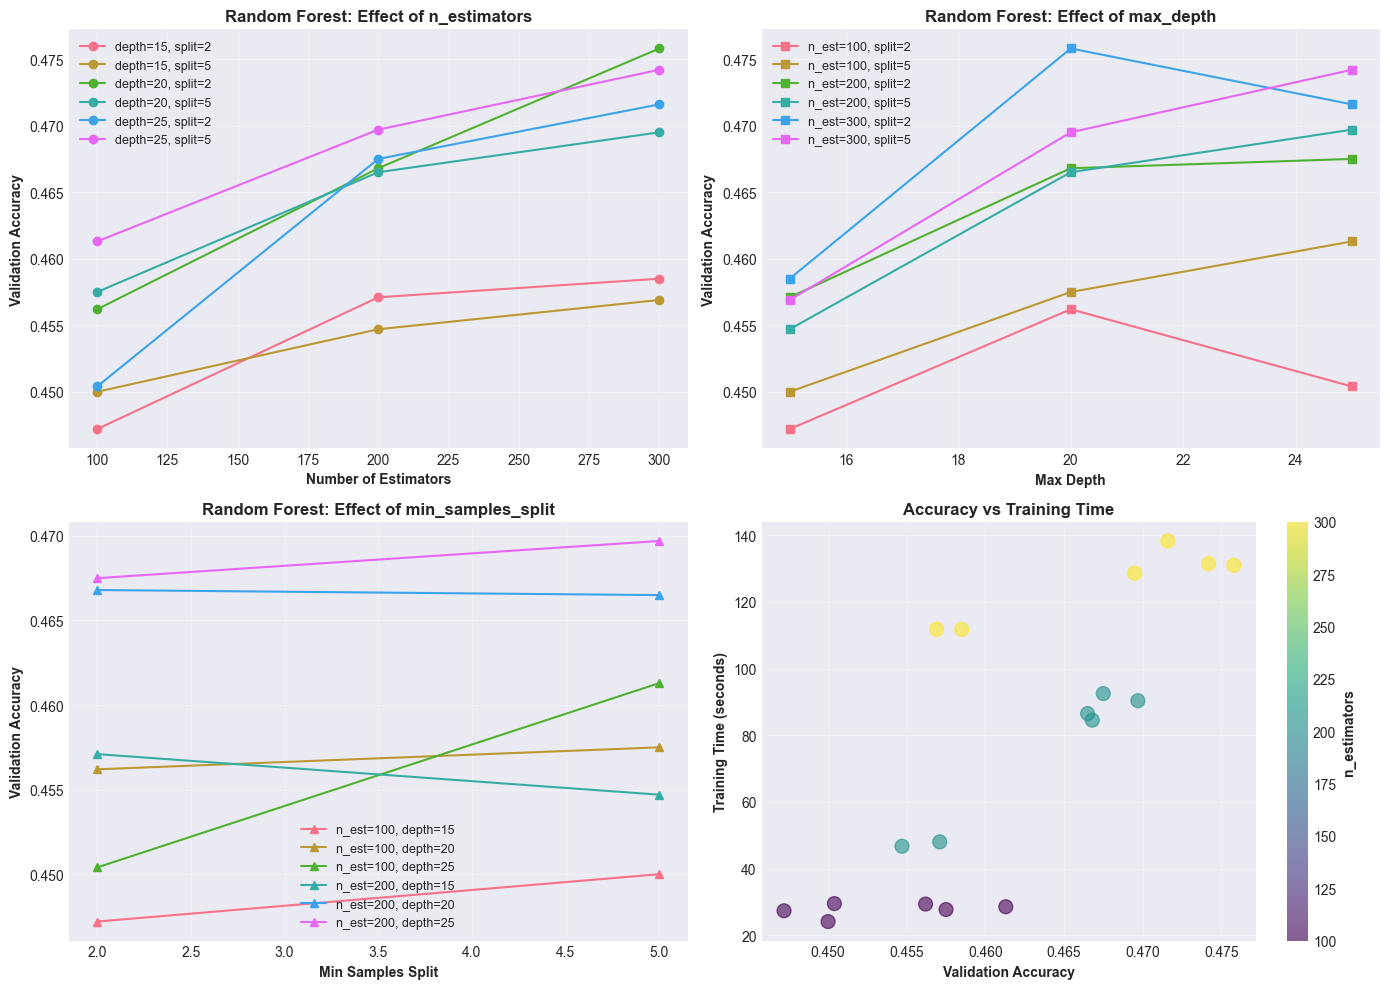

✓ Random Forest tuning visualization completed!


In [10]:
# ============================================================
# CELL 9: Random Forest Tuning Results Visualization
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Effect of n_estimators
ax = axes[0, 0]
for max_d in rf_param_grid['max_depth']:
    for min_split in rf_param_grid['min_samples_split']:
        mask = (rf_results_df['max_depth'] == max_d) & \
               (rf_results_df['min_samples_split'] == min_split)
        data = rf_results_df[mask].sort_values('n_estimators')
        ax.plot(data['n_estimators'], data['val_accuracy'],
               marker='o', label=f'depth={max_d}, split={min_split}')
ax.set_xlabel('Number of Estimators', fontweight='bold')
ax.set_ylabel('Validation Accuracy', fontweight='bold')
ax.set_title('Random Forest: Effect of n_estimators', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# Effect of max_depth
ax = axes[0, 1]
for n_est in rf_param_grid['n_estimators']:
    for min_split in rf_param_grid['min_samples_split']:
        mask = (rf_results_df['n_estimators'] == n_est) & \
               (rf_results_df['min_samples_split'] == min_split)
        data = rf_results_df[mask].sort_values('max_depth')
        ax.plot(data['max_depth'], data['val_accuracy'],
               marker='s', label=f'n_est={n_est}, split={min_split}')
ax.set_xlabel('Max Depth', fontweight='bold')
ax.set_ylabel('Validation Accuracy', fontweight='bold')
ax.set_title('Random Forest: Effect of max_depth', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# Effect of min_samples_split
ax = axes[1, 0]
for n_est in rf_param_grid['n_estimators'][:2]:
    for max_d in rf_param_grid['max_depth']:
        mask = (rf_results_df['n_estimators'] == n_est) & \
               (rf_results_df['max_depth'] == max_d)
        data = rf_results_df[mask].sort_values('min_samples_split')
        ax.plot(data['min_samples_split'], data['val_accuracy'],
               marker='^', label=f'n_est={n_est}, depth={max_d}')
ax.set_xlabel('Min Samples Split', fontweight='bold')
ax.set_ylabel('Validation Accuracy', fontweight='bold')
ax.set_title('Random Forest: Effect of min_samples_split', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# Training time analysis
ax = axes[1, 1]
scatter = ax.scatter(rf_results_df['val_accuracy'], rf_results_df['train_time'],
                    c=rf_results_df['n_estimators'], cmap='viridis', s=100, alpha=0.6)
ax.set_xlabel('Validation Accuracy', fontweight='bold')
ax.set_ylabel('Training Time (seconds)', fontweight='bold')
ax.set_title('Accuracy vs Training Time', fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('n_estimators', fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Random Forest tuning visualization completed!")



In [9]:
# ============================================================
# CELL 10: MLP Hyperparameter Tuning
# ============================================================

print("\n" + "="*80)
print("MLP - HYPERPARAMETER TUNING")
print("="*80)

print("\nTuning Strategy: Grid Search with Early Stopping")
print("Hyperparameters to optimize:")
print("  1. learning_rate: Controls step size in gradient descent")
print("  2. dropout_rate: Controls regularization strength")
print("  3. hidden_layer_config: Architecture complexity")
print("  4. batch_size: Trade-off between speed and gradient accuracy")

# Define hyperparameter grid
mlp_param_grid = {
    'learning_rate': [0.0005, 0.001, 0.002],
    'dropout_rate': [0.2, 0.3, 0.4],
    'hidden_layers': [[256, 128], [512, 256, 128]],
    'batch_size': [32, 64]
}

# Calculate total configurations
total_configs = np.prod([len(v) for v in mlp_param_grid.values()])
print(f"\nTotal MLP configurations to test: {total_configs}")

# Initialize tracking variables
mlp_results_list = []
best_mlp_accuracy = 0
best_mlp_params = None
best_mlp_model = None
config_count = 0

# Start timing
mlp_tune_start = time.time()

print("\nStarting MLP hyperparameter search...")
print("-" * 50)

# Grid search through all combinations
for lr in mlp_param_grid['learning_rate']:
    for dropout in mlp_param_grid['dropout_rate']:
        for hidden_config in mlp_param_grid['hidden_layers']:
            for batch_sz in mlp_param_grid['batch_size']:
                config_count += 1
                
                # Print progress
                print(f"\nConfig {config_count}/{total_configs}:")
                print(f"  lr={lr}, dropout={dropout}, hidden={hidden_config}, batch={batch_sz}")
                
                # Create model with current hyperparameters
                model = create_mlp_model(
                    hidden_layers=hidden_config,
                    dropout_rate=dropout,
                    learning_rate=lr,
                    l2_lambda=0.001  # Keep constant for this search
                )
                
                # Setup callbacks
                early_stop = callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True,
                    verbose=0
                )
                
                reduce_lr = callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=3,
                    min_lr=1e-6,
                    verbose=0
                )
                
                # Train model
                train_start = time.time()
                history = model.fit(
                    X_train_split, y_train_split,
                    validation_data=(X_val, y_val),
                    epochs=100,  # Max epochs (early stopping will likely stop before)
                    batch_size=batch_sz,
                    callbacks=[early_stop, reduce_lr],
                    verbose=0
                )
                train_time = time.time() - train_start
                
                # Evaluate on validation set
                val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
                
                # Get actual number of epochs trained
                epochs_trained = len(history.history['loss'])
                
                # Store results
                result = {
                    'learning_rate': lr,
                    'dropout_rate': dropout,
                    'hidden_layers': str(hidden_config),
                    'batch_size': batch_sz,
                    'val_accuracy': val_acc,
                    'val_loss': val_loss,
                    'train_time': train_time,
                    'epochs': epochs_trained
                }
                mlp_results_list.append(result)
                
                # Print current results
                print(f"  → Val Accuracy: {val_acc:.4f}")
                print(f"  → Val Loss: {val_loss:.4f}")
                print(f"  → Epochs: {epochs_trained} (early stopped)")
                print(f"  → Time: {train_time:.1f}s")
                
                # Check if this is the best model so far
                if val_acc > best_mlp_accuracy:
                    best_mlp_accuracy = val_acc
                    best_mlp_params = {
                        'learning_rate': lr,
                        'dropout_rate': dropout,
                        'hidden_layers': hidden_config,
                        'batch_size': batch_sz
                    }
                    best_mlp_model = model
                    print(f"  ★ New best model! Accuracy: {val_acc:.4f}")
                
                # Clean up memory
                del model
                keras.backend.clear_session()

# Calculate total time
mlp_tune_time = time.time() - mlp_tune_start

# Create results DataFrame
mlp_results_df = pd.DataFrame(mlp_results_list)

# Sort by validation accuracy
mlp_results_df = mlp_results_df.sort_values('val_accuracy', ascending=False)

print("\n" + "="*80)
print("HYPERPARAMETER TUNING COMPLETE")
print("="*80)

print(f"\n📊 Best MLP Configuration:")
print(f"  • Learning rate: {best_mlp_params['learning_rate']}")
print(f"  • Dropout rate: {best_mlp_params['dropout_rate']}")
print(f"  • Hidden layers: {best_mlp_params['hidden_layers']}")
print(f"  • Batch size: {best_mlp_params['batch_size']}")
print(f"  • Best Validation Accuracy: {best_mlp_accuracy:.4f}")

print(f"\n⏱️  Total tuning time: {mlp_tune_time/60:.1f} minutes")
print(f"⚡ Average time per configuration: {mlp_tune_time/total_configs:.1f} seconds")

# Display top 5 configurations
print("\n🏆 Top 5 MLP Configurations:")
print("-" * 50)
top_5 = mlp_results_df.head(5)[['learning_rate', 'dropout_rate', 'hidden_layers', 
                                 'batch_size', 'val_accuracy']]
for idx, row in top_5.iterrows():
    print(f"{row['val_accuracy']:.4f} - lr={row['learning_rate']}, "
          f"dropout={row['dropout_rate']}, layers={row['hidden_layers']}, "
          f"batch={row['batch_size']}")

print("\n✓ MLP hyperparameter tuning completed successfully!")


MLP - HYPERPARAMETER TUNING

Tuning Strategy: Grid Search with Early Stopping
Hyperparameters to optimize:
  1. learning_rate: Controls step size in gradient descent
  2. dropout_rate: Controls regularization strength
  3. hidden_layer_config: Architecture complexity
  4. batch_size: Trade-off between speed and gradient accuracy

Total MLP configurations to test: 36

Starting MLP hyperparameter search...
--------------------------------------------------

Config 1/36:
  lr=0.0005, dropout=0.2, hidden=[256, 128], batch=32


2025-10-24 20:10:14.587100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


  → Val Accuracy: 0.3699
  → Val Loss: 1.9509
  → Epochs: 20 (early stopped)
  → Time: 278.6s
  ★ New best model! Accuracy: 0.3699

Config 2/36:
  lr=0.0005, dropout=0.2, hidden=[256, 128], batch=64
  → Val Accuracy: 0.3771
  → Val Loss: 1.9464
  → Epochs: 69 (early stopped)
  → Time: 476.6s
  ★ New best model! Accuracy: 0.3771

Config 3/36:
  lr=0.0005, dropout=0.2, hidden=[512, 256, 128], batch=32
  → Val Accuracy: 0.3170
  → Val Loss: 2.0803
  → Epochs: 17 (early stopped)
  → Time: 324.3s

Config 4/36:
  lr=0.0005, dropout=0.2, hidden=[512, 256, 128], batch=64
  → Val Accuracy: 0.3404
  → Val Loss: 2.0647
  → Epochs: 19 (early stopped)
  → Time: 190.5s

Config 5/36:
  lr=0.0005, dropout=0.3, hidden=[256, 128], batch=32
  → Val Accuracy: 0.3748
  → Val Loss: 1.8984
  → Epochs: 41 (early stopped)
  → Time: 559.1s

Config 6/36:
  lr=0.0005, dropout=0.3, hidden=[256, 128], batch=64
  → Val Accuracy: 0.3818
  → Val Loss: 1.9075
  → Epochs: 63 (early stopped)
  → Time: 443.7s
  ★ New best


MLP HYPERPARAMETER TUNING - VISUALIZATION


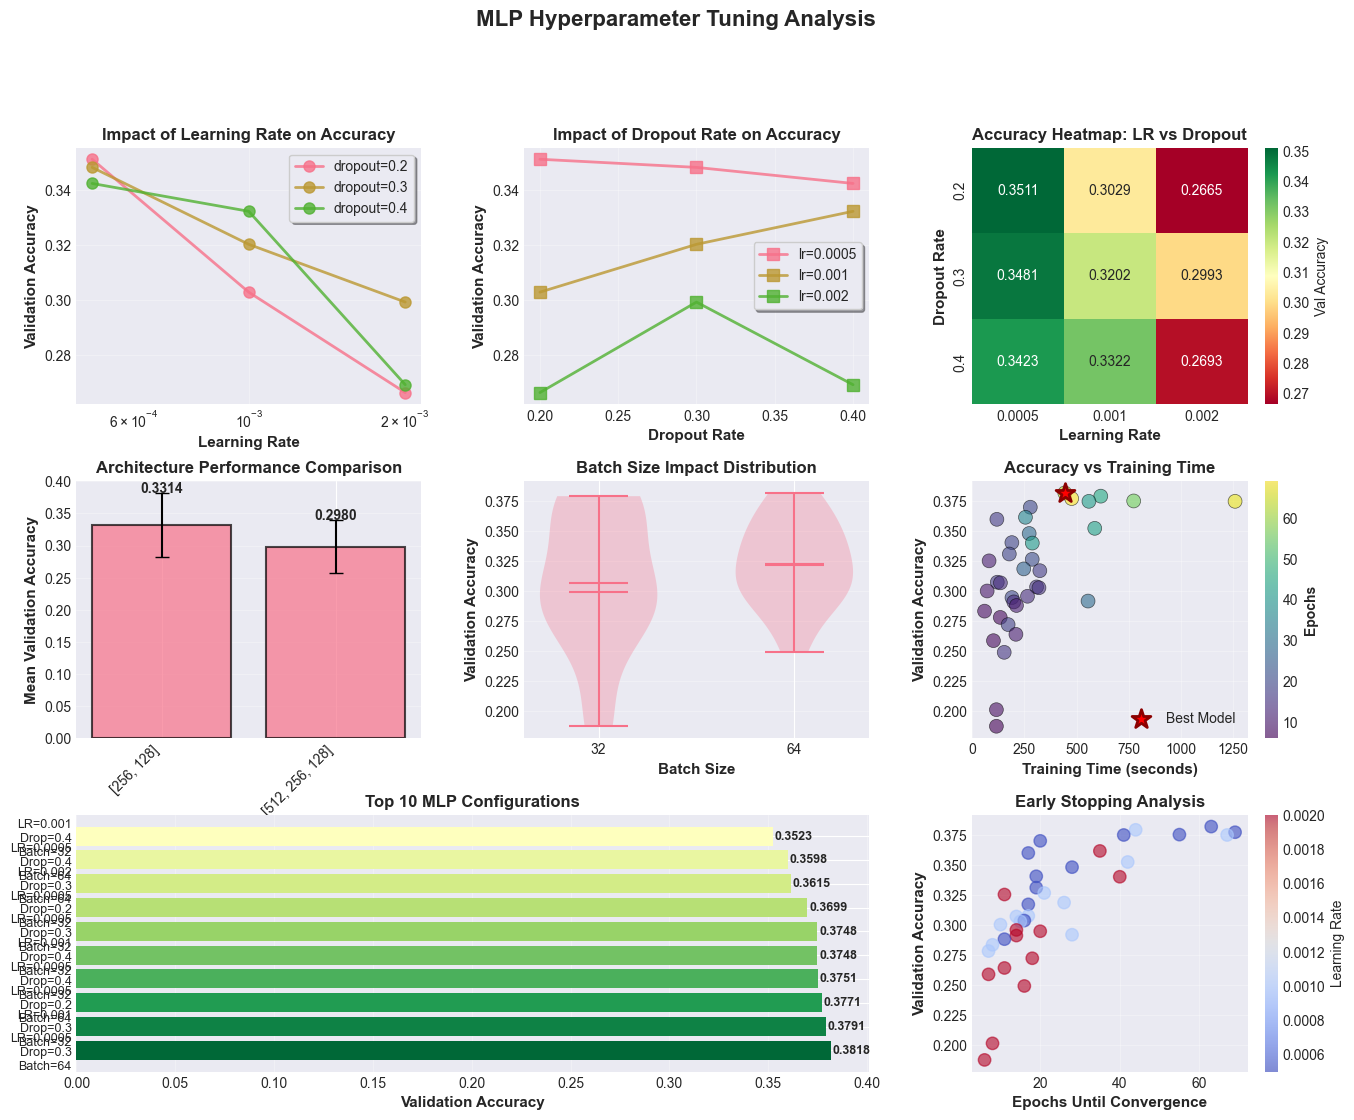


📊 STATISTICAL SUMMARY

🏆 Best Configuration Details:
  • Validation Accuracy: 0.3818
  • Validation Loss: 1.9075
  • Training Time: 443.7 seconds
  • Epochs to Converge: 63

📈 Hyperparameter Impact (by variance in accuracy):
  • learning_rate: variance = 0.001195
    - Best value: learning_rate=0.0005
    - Mean accuracy: 0.3472
  • dropout_rate: variance = 0.000062
    - Best value: dropout_rate=0.3
    - Mean accuracy: 0.3226
  • batch_size: variance = 0.000113
    - Best value: batch_size=64
    - Mean accuracy: 0.3222

🏗️ Architecture Analysis:
  • [256, 128]:
    - Mean: 0.3314 ± 0.0498
    - Best: 0.3818
  • [512, 256, 128]:
    - Mean: 0.2980 ± 0.0414
    - Best: 0.3748

⚡ Efficiency Metrics:
  • Fastest accurate model (>0.5 acc): 

🔗 Correlation Analysis:
  • learning_rate vs accuracy: -0.591
  • dropout_rate vs accuracy: 0.067
  • batch_size vs accuracy: 0.158
  • train_time vs accuracy: 0.568

✅ MLP tuning visualization and analysis completed!


In [11]:
# ============================================================
# CELL 11: MLP Tuning Results Visualization
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*80)
print("MLP HYPERPARAMETER TUNING - VISUALIZATION")
print("="*80)

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# ============================================================
# 1. Learning Rate Effect
# ============================================================
ax1 = fig.add_subplot(gs[0, 0])
for dropout in mlp_param_grid['dropout_rate']:
    mask = mlp_results_df['dropout_rate'] == dropout
    data = mlp_results_df[mask].groupby('learning_rate')['val_accuracy'].mean()
    ax1.plot(data.index, data.values, marker='o', linewidth=2, 
            markersize=8, label=f'dropout={dropout}', alpha=0.8)
ax1.set_xlabel('Learning Rate', fontsize=11, fontweight='bold')
ax1.set_ylabel('Validation Accuracy', fontsize=11, fontweight='bold')
ax1.set_title('Impact of Learning Rate on Accuracy', fontsize=12, fontweight='bold')
ax1.legend(frameon=True, fancybox=True, shadow=True)
ax1.grid(alpha=0.3)
ax1.set_xscale('log')

# ============================================================
# 2. Dropout Rate Effect
# ============================================================
ax2 = fig.add_subplot(gs[0, 1])
for lr in mlp_param_grid['learning_rate']:
    mask = mlp_results_df['learning_rate'] == lr
    data = mlp_results_df[mask].groupby('dropout_rate')['val_accuracy'].mean()
    ax2.plot(data.index, data.values, marker='s', linewidth=2,
            markersize=8, label=f'lr={lr}', alpha=0.8)
ax2.set_xlabel('Dropout Rate', fontsize=11, fontweight='bold')
ax2.set_ylabel('Validation Accuracy', fontsize=11, fontweight='bold')
ax2.set_title('Impact of Dropout Rate on Accuracy', fontsize=12, fontweight='bold')
ax2.legend(frameon=True, fancybox=True, shadow=True)
ax2.grid(alpha=0.3)

# ============================================================
# 3. Heatmap: LR vs Dropout
# ============================================================
ax3 = fig.add_subplot(gs[0, 2])
pivot_table = mlp_results_df.pivot_table(
    values='val_accuracy',
    index='dropout_rate',
    columns='learning_rate',
    aggfunc='mean'
)
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='RdYlGn',
           ax=ax3, cbar_kws={'label': 'Val Accuracy'})
ax3.set_title('Accuracy Heatmap: LR vs Dropout', fontsize=12, fontweight='bold')
ax3.set_xlabel('Learning Rate', fontsize=11, fontweight='bold')
ax3.set_ylabel('Dropout Rate', fontsize=11, fontweight='bold')

# ============================================================
# 4. Architecture Comparison
# ============================================================
ax4 = fig.add_subplot(gs[1, 0])
arch_comparison = mlp_results_df.groupby('hidden_layers')['val_accuracy'].agg(['mean', 'std'])
x = np.arange(len(arch_comparison))
ax4.bar(x, arch_comparison['mean'], yerr=arch_comparison['std'],
       capsize=5, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_xticks(x)
ax4.set_xticklabels(arch_comparison.index, rotation=45, ha='right')
ax4.set_xlabel('Hidden Layer Configuration', fontsize=11, fontweight='bold')
ax4.set_ylabel('Mean Validation Accuracy', fontsize=11, fontweight='bold')
ax4.set_title('Architecture Performance Comparison', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3, axis='y')

# Add value labels on bars
for i, (mean, std) in enumerate(zip(arch_comparison['mean'], arch_comparison['std'])):
    ax4.text(i, mean + std + 0.001, f'{mean:.4f}', ha='center', fontweight='bold')

# ============================================================
# 5. Batch Size Effect
# ============================================================
ax5 = fig.add_subplot(gs[1, 1])
batch_data = mlp_results_df.groupby('batch_size')['val_accuracy'].apply(list)
ax5.violinplot([batch_data[32], batch_data[64]], positions=[0, 1],
              widths=0.6, showmeans=True, showmedians=True)
ax5.set_xticks([0, 1])
ax5.set_xticklabels(['32', '64'])
ax5.set_xlabel('Batch Size', fontsize=11, fontweight='bold')
ax5.set_ylabel('Validation Accuracy', fontsize=11, fontweight='bold')
ax5.set_title('Batch Size Impact Distribution', fontsize=12, fontweight='bold')
ax5.grid(alpha=0.3, axis='y')

# ============================================================
# 6. Training Efficiency
# ============================================================
ax6 = fig.add_subplot(gs[1, 2])
scatter = ax6.scatter(mlp_results_df['train_time'], 
                     mlp_results_df['val_accuracy'],
                     c=mlp_results_df['epochs'], 
                     s=100, alpha=0.6, cmap='viridis',
                     edgecolors='black', linewidth=0.5)
ax6.set_xlabel('Training Time (seconds)', fontsize=11, fontweight='bold')
ax6.set_ylabel('Validation Accuracy', fontsize=11, fontweight='bold')
ax6.set_title('Accuracy vs Training Time', fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax6)
cbar.set_label('Epochs', fontsize=10, fontweight='bold')
ax6.grid(alpha=0.3)

# Highlight best model
best_idx = mlp_results_df['val_accuracy'].idxmax()
best_point = mlp_results_df.loc[best_idx]
ax6.scatter(best_point['train_time'], best_point['val_accuracy'],
           s=200, color='red', marker='*', edgecolors='darkred',
           linewidth=2, label='Best Model', zorder=5)
ax6.legend()

# ============================================================
# 7. Top 10 Configurations
# ============================================================
ax7 = fig.add_subplot(gs[2, :2])
top_10 = mlp_results_df.nlargest(10, 'val_accuracy')
labels = [f"LR={row['learning_rate']}\nDrop={row['dropout_rate']}\nBatch={row['batch_size']}"
         for _, row in top_10.iterrows()]
colors = plt.cm.RdYlGn(np.linspace(0.5, 1, 10))[::-1]
bars = ax7.barh(np.arange(10), top_10['val_accuracy'].values, color=colors)
ax7.set_yticks(np.arange(10))
ax7.set_yticklabels(labels, fontsize=9)
ax7.set_xlabel('Validation Accuracy', fontsize=11, fontweight='bold')
ax7.set_title('Top 10 MLP Configurations', fontsize=12, fontweight='bold')
ax7.grid(alpha=0.3, axis='x')

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, top_10['val_accuracy'].values)):
    ax7.text(acc + 0.001, bar.get_y() + bar.get_height()/2, 
            f'{acc:.4f}', va='center', fontweight='bold', fontsize=9)

# ============================================================
# 8. Convergence Analysis
# ============================================================
ax8 = fig.add_subplot(gs[2, 2])
epochs_vs_acc = ax8.scatter(mlp_results_df['epochs'], 
                           mlp_results_df['val_accuracy'],
                           c=mlp_results_df['learning_rate'], 
                           s=80, alpha=0.6, cmap='coolwarm')
ax8.set_xlabel('Epochs Until Convergence', fontsize=11, fontweight='bold')
ax8.set_ylabel('Validation Accuracy', fontsize=11, fontweight='bold')
ax8.set_title('Early Stopping Analysis', fontsize=12, fontweight='bold')
plt.colorbar(epochs_vs_acc, ax=ax8, label='Learning Rate')
ax8.grid(alpha=0.3)

plt.suptitle('MLP Hyperparameter Tuning Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================
# Statistical Summary
# ============================================================
print("\n📊 STATISTICAL SUMMARY")
print("="*50)

# Best configuration details
best_config = mlp_results_df.iloc[0]
print(f"\n🏆 Best Configuration Details:")
print(f"  • Validation Accuracy: {best_config['val_accuracy']:.4f}")
print(f"  • Validation Loss: {best_config['val_loss']:.4f}")
print(f"  • Training Time: {best_config['train_time']:.1f} seconds")
print(f"  • Epochs to Converge: {best_config['epochs']}")

# Hyperparameter importance (based on variance)
print(f"\n📈 Hyperparameter Impact (by variance in accuracy):")
for param in ['learning_rate', 'dropout_rate', 'batch_size']:
    grouped = mlp_results_df.groupby(param)['val_accuracy']
    variance = grouped.mean().var()
    print(f"  • {param}: variance = {variance:.6f}")
    print(f"    - Best value: {param}={best_config[param]}")
    print(f"    - Mean accuracy: {grouped.mean().max():.4f}")

# Architecture analysis
print(f"\n🏗️ Architecture Analysis:")
for arch in mlp_results_df['hidden_layers'].unique():
    mask = mlp_results_df['hidden_layers'] == arch
    arch_data = mlp_results_df[mask]['val_accuracy']
    print(f"  • {arch}:")
    print(f"    - Mean: {arch_data.mean():.4f} ± {arch_data.std():.4f}")
    print(f"    - Best: {arch_data.max():.4f}")

# Efficiency metrics
print(f"\n⚡ Efficiency Metrics:")
print(f"  • Fastest accurate model (>0.5 acc): ")
efficient_models = mlp_results_df[mlp_results_df['val_accuracy'] > 0.5]
if len(efficient_models) > 0:
    fastest = efficient_models.nsmallest(1, 'train_time').iloc[0]
    print(f"    - Accuracy: {fastest['val_accuracy']:.4f}")
    print(f"    - Time: {fastest['train_time']:.1f}s")
    print(f"    - Config: lr={fastest['learning_rate']}, "
          f"dropout={fastest['dropout_rate']}")

# Correlation analysis
print(f"\n🔗 Correlation Analysis:")
numeric_cols = ['learning_rate', 'dropout_rate', 'batch_size', 'val_accuracy', 'train_time']
correlations = mlp_results_df[numeric_cols].corr()['val_accuracy'].drop('val_accuracy')
for param, corr in correlations.items():
    print(f"  • {param} vs accuracy: {corr:.3f}")

print("\n✅ MLP tuning visualization and analysis completed!")

In [12]:
# ============================================================
# CELL 12: CNN Hyperparameter Tuning
# ============================================================

print("\n" + "-"*80)
print("CNN - HYPERPARAMETER TUNING")
print("-"*80)

print("\nTuning Strategy: Grid Search with Early Stopping and Learning Rate Scheduling")
print("Hyperparameters to optimize:")
print("  1. learning_rate: Step size for gradient updates")
print("  2. dropout_rate: Feature regularization")
print("  3. filter_config: Convolutional feature extraction capacity")

cnn_param_grid = {
    'learning_rate': [0.0005, 0.001, 0.002],
    'dropout_rate': [0.2, 0.3],
    'filters': [[32, 64, 128], [64, 128, 256]],
    'batch_size': [32, 64]
}

print(f"\nTotal CNN configurations: {np.prod([len(v) for v in cnn_param_grid.values()])}")

cnn_results_list = []
best_cnn_accuracy = 0
best_cnn_params = None
cnn_tune_start = time.time()

print("\nTraining CNN models (this may take 45-60 minutes with early stopping)...")

for lr in cnn_param_grid['learning_rate']:
    for dropout in cnn_param_grid['dropout_rate']:
        for filters in cnn_param_grid['filters']:
            for batch_sz in cnn_param_grid['batch_size']:
                # Create model
                model = create_cnn_model(
                    filters=filters,
                    dropout_rate=dropout,
                    learning_rate=lr
                )
                
                # Early stopping callback
                early_stop = callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=7,
                    restore_best_weights=True,
                    verbose=0
                )
                
                # Learning rate scheduler to improve convergence
                reduce_lr = callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=3,
                    min_lr=1e-7,
                    verbose=0
                )
                
                # Train model
                train_start = time.time()
                history = model.fit(
                    X_train_split, y_train_split,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=batch_sz,
                    callbacks=[early_stop, reduce_lr],
                    verbose=0
                )
                train_time = time.time() - train_start
                
                # Evaluate
                val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
                
                cnn_results_list.append({
                    'learning_rate': lr,
                    'dropout_rate': dropout,
                    'filters': str(filters),
                    'batch_size': batch_sz,
                    'val_accuracy': val_acc,
                    'val_loss': val_loss,
                    'train_time': train_time,
                    'epochs': len(history.history['loss'])
                })
                
                print(f"lr={lr}, drop={dropout}, filters={filters}, batch={batch_sz}: "
                      f"Acc={val_acc:.4f}, Epochs={len(history.history['loss'])}, "
                      f"Time={train_time:.1f}s")
                
                if val_acc > best_cnn_accuracy:
                    best_cnn_accuracy = val_acc
                    best_cnn_params = {
                        'learning_rate': lr,
                        'dropout_rate': dropout,
                        'filters': filters,
                        'batch_size': batch_sz
                    }
                    best_cnn_model = model

cnn_tune_time = time.time() - cnn_tune_start
cnn_results_df = pd.DataFrame(cnn_results_list)

print(f"\nBest CNN Parameters:")
print(f"  Learning rate: {best_cnn_params['learning_rate']}")
print(f"  Dropout rate: {best_cnn_params['dropout_rate']}")
print(f"  Filters: {best_cnn_params['filters']}")
print(f"  Batch size: {best_cnn_params['batch_size']}")
print(f"  Best Validation Accuracy: {best_cnn_accuracy:.4f}")
print(f"Total tuning time: {cnn_tune_time/60:.1f} minutes")




--------------------------------------------------------------------------------
CNN - HYPERPARAMETER TUNING
--------------------------------------------------------------------------------

Tuning Strategy: Grid Search with Early Stopping and Learning Rate Scheduling
Hyperparameters to optimize:
  1. learning_rate: Step size for gradient updates
  2. dropout_rate: Feature regularization
  3. filter_config: Convolutional feature extraction capacity

Total CNN configurations: 24

Training CNN models (this may take 45-60 minutes with early stopping)...
lr=0.0005, drop=0.2, filters=[32, 64, 128], batch=32: Acc=0.8516, Epochs=36, Time=1245.8s
lr=0.0005, drop=0.2, filters=[32, 64, 128], batch=64: Acc=0.8416, Epochs=30, Time=527.5s
lr=0.0005, drop=0.2, filters=[64, 128, 256], batch=32: Acc=0.8607, Epochs=23, Time=806.9s
lr=0.0005, drop=0.2, filters=[64, 128, 256], batch=64: Acc=0.8598, Epochs=22, Time=481.0s
lr=0.0005, drop=0.3, filters=[32, 64, 128], batch=32: Acc=0.8598, Epochs=48, Time=1

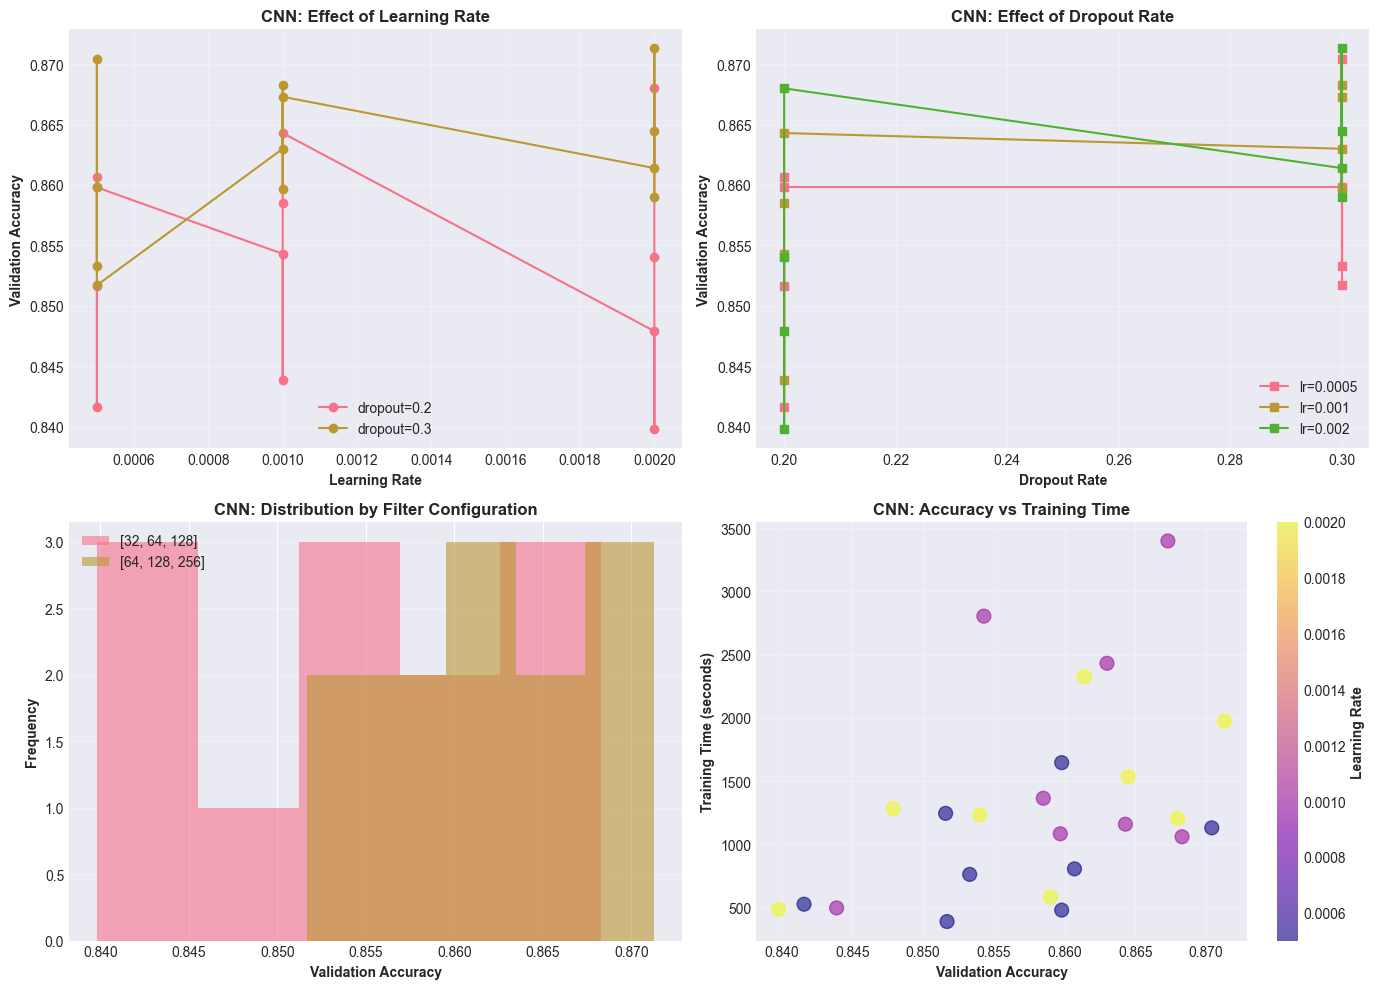

✓ CNN tuning visualization completed!


In [13]:

# ============================================================
# CELL 13: CNN Tuning Results Visualization
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Effect of learning rate
ax = axes[0, 0]
for dropout in cnn_param_grid['dropout_rate']:
    mask = cnn_results_df['dropout_rate'] == dropout
    data = cnn_results_df[mask].sort_values('learning_rate')
    ax.plot(data['learning_rate'], data['val_accuracy'],
           marker='o', label=f'dropout={dropout}')
ax.set_xlabel('Learning Rate', fontweight='bold')
ax.set_ylabel('Validation Accuracy', fontweight='bold')
ax.set_title('CNN: Effect of Learning Rate', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Effect of dropout rate
ax = axes[0, 1]
for lr in cnn_param_grid['learning_rate']:
    mask = cnn_results_df['learning_rate'] == lr
    data = cnn_results_df[mask].sort_values('dropout_rate')
    ax.plot(data['dropout_rate'], data['val_accuracy'],
           marker='s', label=f'lr={lr}')
ax.set_xlabel('Dropout Rate', fontweight='bold')
ax.set_ylabel('Validation Accuracy', fontweight='bold')
ax.set_title('CNN: Effect of Dropout Rate', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Filter configuration comparison
ax = axes[1, 0]
filter_configs = cnn_results_df['filters'].unique()
for filters in filter_configs:
    mask = cnn_results_df['filters'] == filters
    ax.hist(cnn_results_df[mask]['val_accuracy'], alpha=0.6,
           label=filters, bins=5)
ax.set_xlabel('Validation Accuracy', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('CNN: Distribution by Filter Configuration', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3, axis='y')

# Training time vs accuracy
ax = axes[1, 1]
scatter = ax.scatter(cnn_results_df['val_accuracy'], cnn_results_df['train_time'],
                    c=cnn_results_df['learning_rate'], cmap='plasma', s=100, alpha=0.6)
ax.set_xlabel('Validation Accuracy', fontweight='bold')
ax.set_ylabel('Training Time (seconds)', fontweight='bold')
ax.set_title('CNN: Accuracy vs Training Time', fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Learning Rate', fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ CNN tuning visualization completed!")



In [20]:
# ============================================================
# CELL 14: Train Final Models with Best Parameters (CORRECTED)
# ============================================================

print("\n" + "="*80)
print("SECTION 4: FINAL MODEL TRAINING AND EVALUATION")
print("="*80)

print("\nTraining final models with best hyperparameters on full training set...")

# ===== Random Forest Final Model =====
print("\n" + "-"*80)
print("FINAL RANDOM FOREST MODEL")
print("-"*80)

rf_final = RandomForestClassifier(**best_rf_params, n_jobs=-1, random_state=42)
print(f"Training with parameters: {best_rf_params}")
rf_train_start = time.time()
rf_final.fit(X_train_flat, y_train)
rf_train_time = time.time() - rf_train_start

print(f"Training time: {rf_train_time:.2f} seconds")
print("Evaluating on test set...")

rf_pred = rf_final.predict(X_test_flat)
rf_test_acc = accuracy_score(y_test, rf_pred)
rf_test_precision = precision_score(y_test, rf_pred, average='weighted')
rf_test_recall = recall_score(y_test, rf_pred, average='weighted')
rf_test_f1 = f1_score(y_test, rf_pred, average='weighted')

print(f"\nRandom Forest Test Results:")
print(f"  Accuracy:  {rf_test_acc:.4f}")
print(f"  Precision: {rf_test_precision:.4f}")
print(f"  Recall:    {rf_test_recall:.4f}")
print(f"  F1-Score:  {rf_test_f1:.4f}")

# ===== MLP Final Model (CORRECTED) =====
print("\n" + "-"*80)
print("FINAL MLP MODEL")
print("-"*80)

# Create MLP model with flattened input
mlp_final = create_mlp_model(
    input_size=3072,  # Flattened size
    hidden_layers=best_mlp_params['hidden_layers'],
    dropout_rate=best_mlp_params['dropout_rate'],
    learning_rate=best_mlp_params['learning_rate']
)

print(f"Training with parameters:")
print(f"  Learning rate: {best_mlp_params['learning_rate']}")
print(f"  Dropout rate: {best_mlp_params['dropout_rate']}")
print(f"  Hidden layers: {best_mlp_params['hidden_layers']}")
print(f"  Batch size: {best_mlp_params['batch_size']}")

# Callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=0
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=0
)

# CORRECTED: Train on FLATTENED data
mlp_train_start = time.time()
mlp_history = mlp_final.fit(
    X_train_flat.reshape(-1, 32, 32, 3),  # ✅ Reshape for Flatten layer input
    y_train,
    validation_data=(X_val_flat.reshape(-1, 32, 32, 3), y_val),  # ✅ 
    epochs=100,
    batch_size=best_mlp_params['batch_size'],
    callbacks=[early_stop, reduce_lr],
    verbose=0
)
mlp_train_time = time.time() - mlp_train_start

print(f"Training time: {mlp_train_time:.2f} seconds ({len(mlp_history.history['loss'])} epochs)")

# CORRECTED: Evaluate on properly shaped test data
mlp_test_loss, mlp_test_acc = mlp_final.evaluate(
    X_test_flat.reshape(-1, 32, 32, 3),  # ✅ Proper shape for Flatten layer
    y_test, 
    verbose=0
)

# CORRECTED: Predict on properly shaped test data
mlp_pred = mlp_final.predict(
    X_test_flat.reshape(-1, 32, 32, 3),  # ✅ 
    verbose=0
).argmax(axis=1)

mlp_precision = precision_score(y_test, mlp_pred, average='weighted')
mlp_recall = recall_score(y_test, mlp_pred, average='weighted')
mlp_f1 = f1_score(y_test, mlp_pred, average='weighted')

print(f"\nMLP Test Results:")
print(f"  Accuracy:  {mlp_test_acc:.4f}")
print(f"  Precision: {mlp_precision:.4f}")
print(f"  Recall:    {mlp_recall:.4f}")
print(f"  F1-Score:  {mlp_f1:.4f}")

# ===== CNN Final Model =====
print("\n" + "-"*80)
print("FINAL CNN MODEL")
print("-"*80)

cnn_final = create_cnn_model(
    filters=best_cnn_params['filters'],
    dropout_rate=best_cnn_params['dropout_rate'],
    learning_rate=best_cnn_params['learning_rate']
)

print(f"Training with parameters:")
print(f"  Learning rate: {best_cnn_params['learning_rate']}")
print(f"  Dropout rate: {best_cnn_params['dropout_rate']}")
print(f"  Filters: {best_cnn_params['filters']}")
print(f"  Batch size: {best_cnn_params['batch_size']}")

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=0
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=0
)

# CNN uses image-shaped data (correct as is)
cnn_train_start = time.time()
cnn_history = cnn_final.fit(
    X_train_normalized,  # Full training set
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=best_cnn_params['batch_size'],
    callbacks=[early_stop, reduce_lr],
    verbose=0
)
cnn_train_time = time.time() - cnn_train_start

print(f"Training time: {cnn_train_time:.2f} seconds ({len(cnn_history.history['loss'])} epochs)")

cnn_test_loss, cnn_test_acc = cnn_final.evaluate(X_test_normalized, y_test, verbose=0)
cnn_pred = cnn_final.predict(X_test_normalized, verbose=0).argmax(axis=1)
cnn_precision = precision_score(y_test, cnn_pred, average='weighted')
cnn_recall = recall_score(y_test, cnn_pred, average='weighted')
cnn_f1 = f1_score(y_test, cnn_pred, average='weighted')

print(f"\nCNN Test Results:")
print(f"  Accuracy:  {cnn_test_acc:.4f}")
print(f"  Precision: {cnn_precision:.4f}")
print(f"  Recall:    {cnn_recall:.4f}")
print(f"  F1-Score:  {cnn_f1:.4f}")

print("\n✓ Final model training completed!")


SECTION 4: FINAL MODEL TRAINING AND EVALUATION

Training final models with best hyperparameters on full training set...

--------------------------------------------------------------------------------
FINAL RANDOM FOREST MODEL
--------------------------------------------------------------------------------
Training with parameters: {'n_estimators': 300, 'max_depth': 25, 'min_samples_split': 5}
Training time: 38.97 seconds
Evaluating on test set...

Random Forest Test Results:
  Accuracy:  0.4849
  Precision: 0.4805
  Recall:    0.4849
  F1-Score:  0.4799

--------------------------------------------------------------------------------
FINAL MLP MODEL
--------------------------------------------------------------------------------
Training with parameters:
  Learning rate: 0.0005
  Dropout rate: 0.3
  Hidden layers: [256, 128]
  Batch size: 64
Training time: 667.35 seconds (68 epochs)

MLP Test Results:
  Accuracy:  0.3747
  Precision: 0.3657
  Recall:    0.3747
  F1-Score:  0.3657

-


COMPREHENSIVE RESULTS COMPARISON

    Algorithm  Accuracy  Precision  Recall  F1-Score  Training Time (s) Parameters (approx)
Random Forest    0.4849   0.480517  0.4849  0.479894          38.971651                ~90K
          MLP    0.3747   0.365683  0.3747  0.365658         667.345559               ~1.7M
          CNN    0.8837   0.883673  0.8837  0.883180        6483.573672               ~0.8M


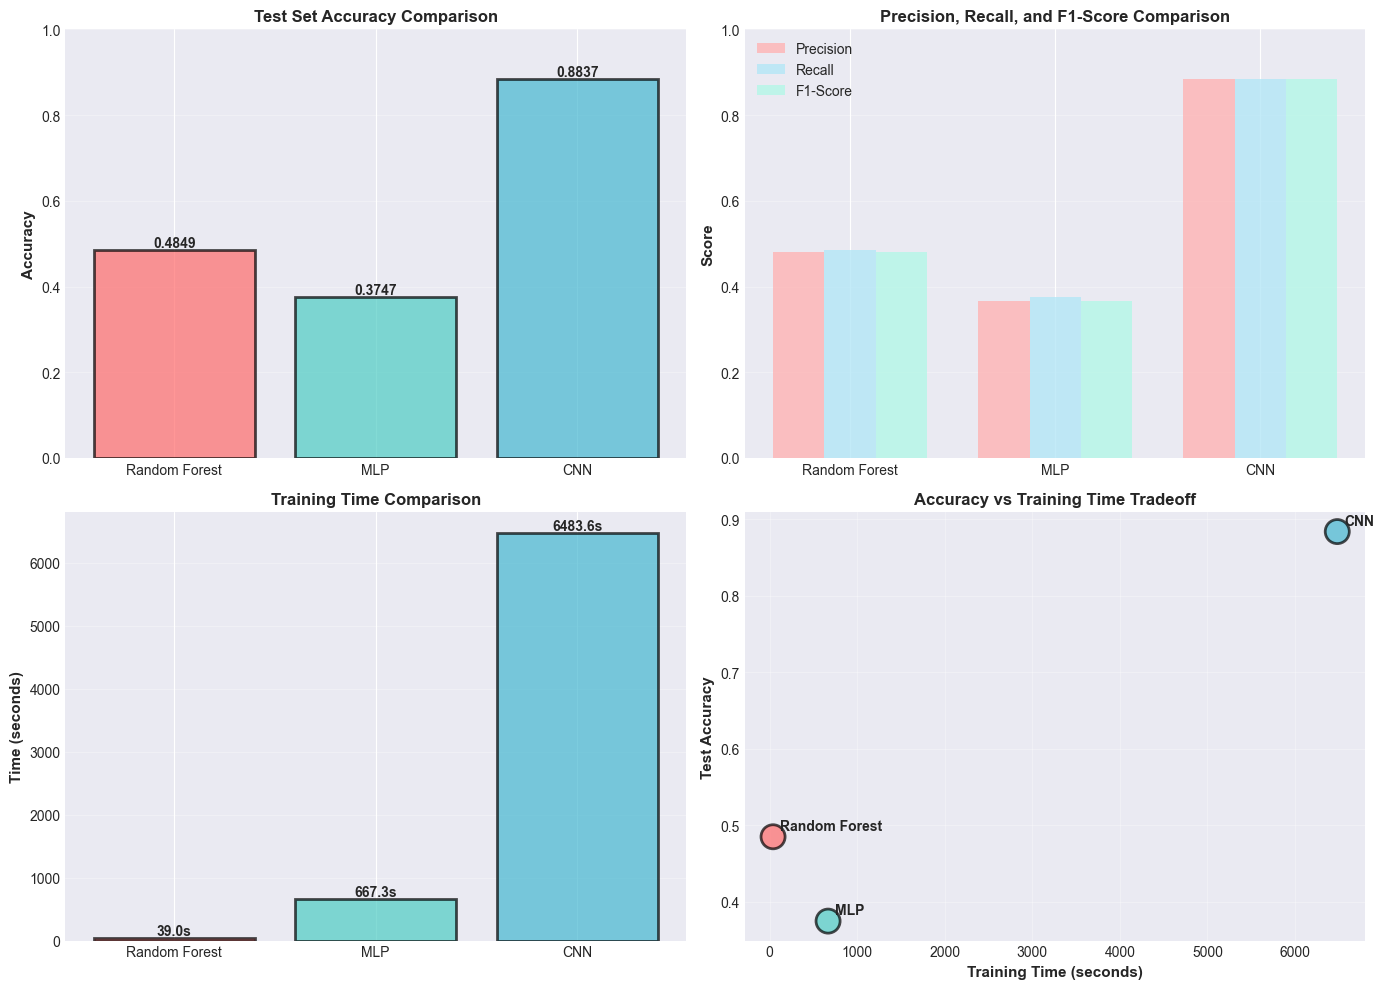


✓ Results comparison completed!


In [21]:

# ============================================================
# CELL 15: Final Results Comparison Table
# ============================================================

print("\n" + "="*80)
print("COMPREHENSIVE RESULTS COMPARISON")
print("="*80)

results_summary = pd.DataFrame({
    'Algorithm': ['Random Forest', 'MLP', 'CNN'],
    'Accuracy': [rf_test_acc, mlp_test_acc, cnn_test_acc],
    'Precision': [rf_test_precision, mlp_precision, cnn_precision],
    'Recall': [rf_test_recall, mlp_recall, cnn_recall],
    'F1-Score': [rf_test_f1, mlp_f1, cnn_f1],
    'Training Time (s)': [rf_train_time, mlp_train_time, cnn_train_time],
    'Parameters (approx)': ['~90K', '~1.7M', '~0.8M']
})

print("\n" + results_summary.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy comparison
ax = axes[0, 0]
algorithms = results_summary['Algorithm']
colors_acc = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = ax.bar(algorithms, results_summary['Accuracy'], color=colors_acc, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Accuracy', fontweight='bold', fontsize=11)
ax.set_title('Test Set Accuracy Comparison', fontweight='bold', fontsize=12)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Precision, Recall, F1 comparison
ax = axes[0, 1]
x = np.arange(len(algorithms))
width = 0.25
ax.bar(x - width, results_summary['Precision'], width, label='Precision', alpha=0.8, color='#FFB4B4')
ax.bar(x, results_summary['Recall'], width, label='Recall', alpha=0.8, color='#B4E7F7')
ax.bar(x + width, results_summary['F1-Score'], width, label='F1-Score', alpha=0.8, color='#B4F7E7')
ax.set_ylabel('Score', fontweight='bold', fontsize=11)
ax.set_title('Precision, Recall, and F1-Score Comparison', fontweight='bold', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Training time comparison
ax = axes[1, 0]
bars = ax.bar(algorithms, results_summary['Training Time (s)'], color=colors_acc, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Time (seconds)', fontweight='bold', fontsize=11)
ax.set_title('Training Time Comparison', fontweight='bold', fontsize=12)
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')

# Accuracy vs Time tradeoff
ax = axes[1, 1]
scatter = ax.scatter(results_summary['Training Time (s)'], results_summary['Accuracy'],
                    s=300, c=colors_acc, alpha=0.7, edgecolors='black', linewidth=2)
for idx, algo in enumerate(algorithms):
    ax.annotate(algo, 
               (results_summary['Training Time (s)'][idx], results_summary['Accuracy'][idx]),
               xytext=(5, 5), textcoords='offset points', fontweight='bold')
ax.set_xlabel('Training Time (seconds)', fontweight='bold', fontsize=11)
ax.set_ylabel('Test Accuracy', fontweight='bold', fontsize=11)
ax.set_title('Accuracy vs Training Time Tradeoff', fontweight='bold', fontsize=12)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Results comparison completed!")




--------------------------------------------------------------------------------
DETAILED PER-CLASS ANALYSIS
--------------------------------------------------------------------------------


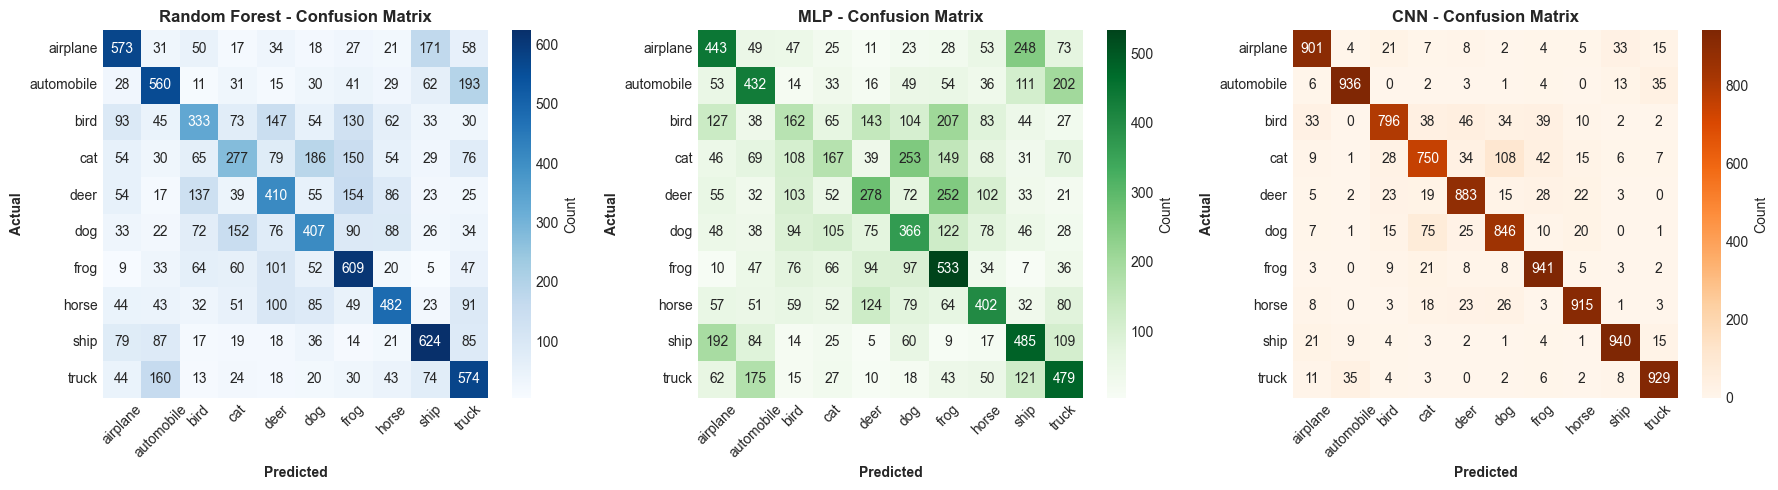


Per-Class Accuracy Analysis:
--------------------------------------------------------------------------------

Random Forest:
  airplane    : 0.5730
  automobile  : 0.5600
  bird        : 0.3330
  cat         : 0.2770
  deer        : 0.4100
  dog         : 0.4070
  frog        : 0.6090
  horse       : 0.4820
  ship        : 0.6240
  truck       : 0.5740

MLP:
  airplane    : 0.4430
  automobile  : 0.4320
  bird        : 0.1620
  cat         : 0.1670
  deer        : 0.2780
  dog         : 0.3660
  frog        : 0.5330
  horse       : 0.4020
  ship        : 0.4850
  truck       : 0.4790

CNN:
  airplane    : 0.9010
  automobile  : 0.9360
  bird        : 0.7960
  cat         : 0.7500
  deer        : 0.8830
  dog         : 0.8460
  frog        : 0.9410
  horse       : 0.9150
  ship        : 0.9400
  truck       : 0.9290


In [22]:

# ============================================================
# CELL 16: Confusion Matrices and Detailed Analysis
# ============================================================

print("\n" + "-"*80)
print("DETAILED PER-CLASS ANALYSIS")
print("-"*80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Random Forest confusion matrix
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Count'})
axes[0].set_title('Random Forest - Confusion Matrix', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Predicted', fontweight='bold')
axes[0].set_ylabel('Actual', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# MLP confusion matrix
cm_mlp = confusion_matrix(y_test, mlp_pred)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens', ax=axes[1],
           xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Count'})
axes[1].set_title('MLP - Confusion Matrix', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Predicted', fontweight='bold')
axes[1].set_ylabel('Actual', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

# CNN confusion matrix
cm_cnn = confusion_matrix(y_test, cnn_pred)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Oranges', ax=axes[2],
           xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Count'})
axes[2].set_title('CNN - Confusion Matrix', fontweight='bold', fontsize=12)
axes[2].set_xlabel('Predicted', fontweight='bold')
axes[2].set_ylabel('Actual', fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Per-class accuracy analysis
print("\nPer-Class Accuracy Analysis:")
print("-" * 80)

for algo_name, y_pred, cm in [("Random Forest", rf_pred, cm_rf),
                               ("MLP", mlp_pred, cm_mlp),
                               ("CNN", cnn_pred, cm_cnn)]:
    print(f"\n{algo_name}:")
    per_class_acc = np.diag(cm) / cm.sum(axis=1)
    for class_idx, class_name in enumerate(class_names):
        print(f"  {class_name:12s}: {per_class_acc[class_idx]:.4f}")




--------------------------------------------------------------------------------
TRAINING DYNAMICS ANALYSIS
--------------------------------------------------------------------------------


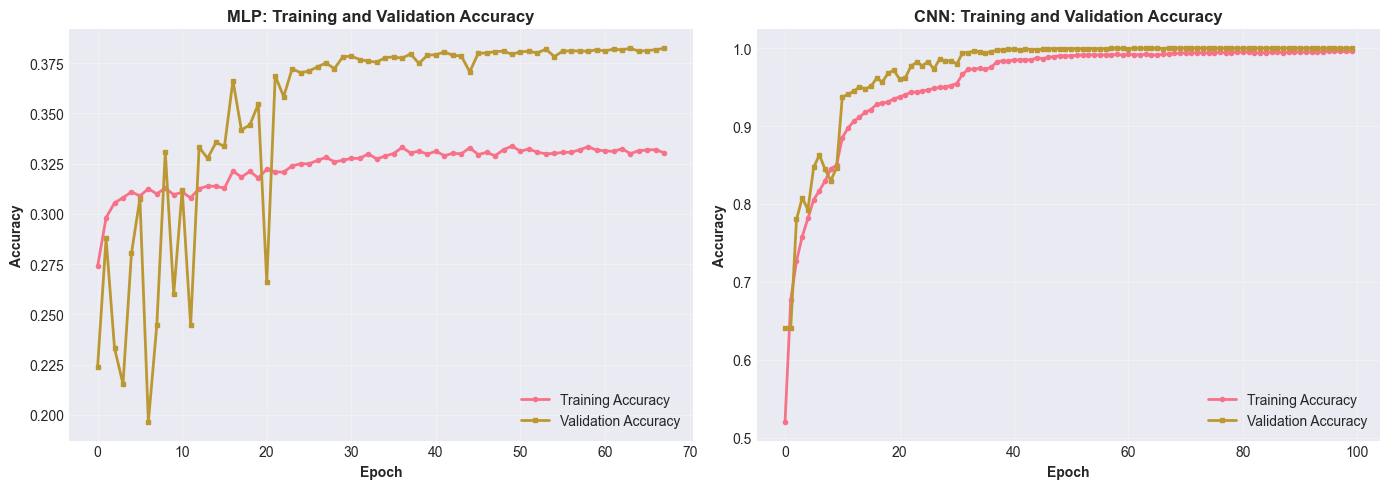

✓ Training dynamics analysis completed!

ASSIGNMENT COMPLETE - All models trained and evaluated successfully!


In [23]:

# ============================================================
# CELL 17: Training History Visualization (Neural Networks)
# ============================================================

print("\n" + "-"*80)
print("TRAINING DYNAMICS ANALYSIS")
print("-"*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MLP training history
ax = axes[0]
ax.plot(mlp_history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o', markersize=3)
ax.plot(mlp_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s', markersize=3)
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('MLP: Training and Validation Accuracy', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# CNN training history
ax = axes[1]
ax.plot(cnn_history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o', markersize=3)
ax.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s', markersize=3)
ax.set_xlabel('Epoch', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('CNN: Training and Validation Accuracy', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Training dynamics analysis completed!")

print("\n" + "="*80)
print("ASSIGNMENT COMPLETE - All models trained and evaluated successfully!")
print("="*80)